<a href="https://colab.research.google.com/github/Kshitij-Ambilduke/Meme-vs-Notes/blob/master/ConvNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Memes vs Notes Classifier**

First we mount the drive containing the dataset so that we can read data from the drive and transform it as we want to.
To do this we run the below code block and copy the password generated for us in the link provided by logging in and pasting it here.


```python
drive.mount('/content/drive') can be replaced by drive.mount('/content/gdrive)
``` 




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


After having access to all the images in the dataset, we go ahead and import some important packages that will help us in reading the dataset, preprocessing and using the preprocessed data to build our model that differenciates between memes and notes.
```python
import os # To loacte the data and making list of all the data in a particular folder
import cv2 # For reading the images, resizing them and converting them to a desired colour space
import random # For Shuffling the data
import torch # For Neural Networks
```

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import random
import numpy as np

Defining path for memes as ```meme_path``` and the path for notes as ```note_path```

In [3]:
meme_path = "/content/drive/My Drive/dataset stage 0 /meme"
note_path = "/content/drive/My Drive/dataset stage 0 /note"

Defining a pseudo-dataloader as ```dataloader``` so as to load the data from the path that is passed as an argument ```folder``` and the label to be given to this  folder is passed through the argument ```label```.
This function can be fine tuned so as to the desired form of the images from the folder.
Note that all the images from the same folder are labeled with the 2nd argument passed in the function. 
Here we are using the size ```(100 x 100)``` and the grayscale colour.
The function returns 2 lists, 1st the resized images and 2nd the labels for these images.

In [4]:
def dataloader(folder,label):
    images=[]
    labels=[]
    for file in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,file),0)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (100,100))
        images.append(img)
        labels.append(label)
    return images, labels

Defining variables for containing the memes and the labels for meme as ```meme``` and ```memelabel``` respectively. Similarly defining variables for notes and label for notes as ```note``` and ```notelabel``` respectively.

In [5]:
meme, memelabel = dataloader(meme_path, 1)
note, notelabel = dataloader(note_path, 0)



Converting all the lists into numpy arrays and reshaping them in the format ```(number of images x channels in the image x height of the image x width of the image)```. For a RGB image the number of channels will be 3 and for a RGB image, the number of channel will be 1.



In [6]:
meme = np.array(meme)
memelabel = np.array(memelabel)
#print(meme.__len__())
meme = meme.reshape(800,1,100,100)
note = np.array(note)
note = note.reshape(800,1,100,100)
notelabel = np.array(notelabel)
#print(len(notelabel))

Zipping together the images and labels so as to Shuffle them.

In [7]:
memezip = list(zip(meme, memelabel))
notezip = list(zip(note, notelabel))

Concatenating the two lists in the variable ```toshuffle``` then shuffling the list containing the zips of both the labels using  ```random.shuffle()``` then unzipping the shuffled list of zips into two variables ```xtest``` and ```ytest``` where ```xtest``` is the list containing the shuffled images and ```ytest``` is the list containing the labels for these images.
In the same way ```xtrain```,```ytrain```,```xval```,```yval``` is created.


In [32]:
toshuffle = []
toshuffle = memezip[0:750] + notezip[0:750]
random.shuffle(toshuffle)
xtrain, ytrain = list(zip(*toshuffle))

toshuffle = []
toshuffle = memezip[750:775] + notezip[750:775]
random.shuffle(toshuffle)
xtest, ytest = list(zip(*toshuffle))

toshuffle = []
toshuffle = memezip[775:] + notezip[775:]
random.shuffle(toshuffle)
xval, yval = list(zip(*toshuffle))

Now that we have our data all sorted out, its time to convert our data into tensor so as to use it with pytorch module.
While calculating the loss, the labels of the data are expected to be of ```Long``` datatype so we convert the labels into ```long``` datatype.

We have also segregated the data into training, validation and testing data.
Out of the **1600** images available to us in the dataset, we chose **1500** images for training, 50 for validation and **50** for testing. This gives us a training set of **93.75%** of the dataset and the validation and testing set bith **3.125%** of the total dataset. Here we have adopted a very primitive technique of normalization that being dividing all the pixels of the image by 255 thereby bringing each of the pixels' value between 0 and 1.

In [33]:
xtrain = torch.Tensor(xtrain)
xtest = torch.Tensor(xtest)
xval = torch.Tensor(xval)
ytrain = torch.Tensor(ytrain).long()
ytest = torch.Tensor(ytest).long()
yval = torch.Tensor(yval).long()
xtrain/=255.0
xtest/=255.0
xval /=255.0

Now we start to define our neural network. We start by creating a class ```ConvNet``` which inherit from the parent class of pytorch ```nn.Module```. The attributes of this class are the layers of the neural network are the layers of our convolutional neural network. We use ```nn.Sequntial``` for bunching a couple of layes together.
The Architechture of the neural network is as follows:


1.   Convolutional layer taking 1 channel and giving 16 channels with a kernel size of ```5x5``` followed by a ReLU activation and then a Max Pool layer with a ```kernel_size = 2``` and ```stride = 2```
2.   Convolutional layer taking 16 channel and giving 32 channels with a kernel size of ```5x5``` followed by a ReLU activation and then a Max Pool layer with a ```kernel_size = 2``` and ```stride = 2```
3.   Convolutional layer taking 32 channel and giving 48 channels with a kernel size of ```5x5``` followed by a ReLU activation and then a Max Pool layer with a ```kernel_size = 2``` and ```stride = 2```
4.    Couple of Linear layer with ```input_features = 2888``` i.e. the flattened output of the convolutional layers, then hidden layer containing ```500``` neurons and the output layer containing ```2``` neurons which depict the binary nature of our classification.


In [34]:
class ConvNet(nn.Module):
  
  def __init__(self):
    super().__init__()
    
    self.l1 = nn.Sequential(nn.Conv2d(1,16,5),
                       nn.ReLU(),
                       nn.MaxPool2d(2,2))
    
    self.l2 = nn.Sequential(nn.Conv2d(16,32,3),
                       nn.ReLU(),
                       nn.MaxPool2d(2,2))
    
    self.l3 = nn.Sequential(nn.Conv2d(32,48,5),
                       nn.ReLU(),
                       nn.MaxPool2d(2,2))

    self.l4 = nn.Sequential(nn.Linear(48*9*9,500),
                       nn.Linear(500,2))
    
  def forward(self,x):

    x = self.l1(x)
    x = self.l2(x)
    x = self.l3(x)
    x = x.flatten(1)
    x = self.l4(x)
    return x

Now we create an instance of the class we just created and print out that instance just to make sure everything is just as we wanted.

In [35]:
net = ConvNet()
print(net)

ConvNet(
  (l1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (l2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (l3): Sequential(
    (0): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (l4): Sequential(
    (0): Linear(in_features=3888, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=2, bias=True)
  )
)


Now it's time we define our optimizer and loss function. Pytorch provied optimizer in the ```torch.optim``` package so we define our optimizer as ```torch.optim.Adam``` optimizer and the loss function as ```nn.CrossEntropyLoss```. This loss function combines the ```softmax``` and the ```NLLloss``` so we need not define the softmax layer at the end of our network. The optimizer requires 2 arguments, 1st the parameters on which the optimization should be performed and 2nd the learning rate. 

In [36]:
optimizer = torch.optim.Adam(net.parameters(),lr=0.0001)
lossfn = nn.CrossEntropyLoss()

Finally with all the data ready and the loss and optimiser defined, we can now build our accuracy function so as to track the training, testing and validation accuracy.
This function takes 2 arguments ```label``` and ```pred```.
The argument ```label``` is the actual label matrix that we made while we made the dataset and ```pred``` is a matrix output by the network with contains the confidence score of what the network thinks should be the prediction of the data. We use ```torch.argmax``` to get the index of the highest prediction. The argument ```dim=1``` specifies that for a particular example, the confidence score is distributed along the horizontal. Then by comparing the values in the 2 matrices, we can get the accuracy easily. 
> While calculating the accuracy, we need to apply the softmax layer so as to get the probability distribution of of the confidence score of the model. This is done because we haven't applied Softmax layer to the output but while loss calculation, due to usage of ```nn.CrossEntropyLoss``` we dont need to separately use Softmax .


In [37]:
def accuracy(label, pred):
  pred = F.softmax(pred, dim=1)
  count =0
  pred = torch.argmax(pred, dim=1, keepdims=True)
  pred = pred.reshape(pred.shape[0])
  for i in range(len(label)):
    if label[i]==pred[i]:
      count+=1
  return 100*count/label.shape[0]


Now we define our main loop which will contain everything and it will do all the calculations necessary for our network to learn. I have chosen a mini-batch of size 50 and 3 epochs. The training accuracy, testing accuracy and validation accuracy is stored in the lists ```trainacc```,```testacc``` and ```valacc``` respectively. Similarly, the training and validation loss is stored in ```trainloss``` and ```valloss``` respectively.

In [38]:
trainacc = []
testacc = []
trainloss = []
testloss = []
valacc = []
valloss = []

for i in range(7):
    k=0
    for j in range(30): 
      
      output = net.forward(xtrain[k:k+50])
      loss = lossfn(output, ytrain[k:k+50])
        
      k+=50
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
    with torch.no_grad():

      accu = accuracy(ytrain, net.forward(xtrain))
      vloss = lossfn(net.forward(xval),yval)
      tacc = accuracy(ytest, net.forward(xtest))
      vacc = accuracy(yval,net.forward(xval))

    
    print(f"training loss:{loss}")
    trainloss.append(loss)
    print(f"validation loss:{vloss}")
    valloss.append(vloss.item())
    print(f"training accuracy:{accu}")
    trainacc.append(accu)
    print(f"validation accuracy:{vacc}")
    valacc.append(vacc)
    print(f"testing accuracy:{tacc}")
    testacc.append(tacc)
    print()

training loss:0.23529256880283356
validation loss:0.18976402282714844
training accuracy:96.66666666666667
validation accuracy:98.0
testing accuracy:94.0

training loss:0.0788077861070633
validation loss:0.09432152658700943
training accuracy:96.66666666666667
validation accuracy:96.0
testing accuracy:96.0

training loss:0.0689488872885704
validation loss:0.08360300958156586
training accuracy:96.8
validation accuracy:96.0
testing accuracy:96.0

training loss:0.06025213375687599
validation loss:0.07492224872112274
training accuracy:97.13333333333334
validation accuracy:96.0
testing accuracy:96.0

training loss:0.05388428643345833
validation loss:0.07114923000335693
training accuracy:97.33333333333333
validation accuracy:96.0
testing accuracy:96.0

training loss:0.04905453324317932
validation loss:0.06724778562784195
training accuracy:97.6
validation accuracy:96.0
testing accuracy:96.0

training loss:0.045979298651218414
validation loss:0.070273257791996
training accuracy:97.93333333333334

## **Note:**
> If you are re-running the program start from the point where we made ```xtrain```,```ytrain``` ....


In [39]:
print(xtrain.shape)

torch.Size([1500, 1, 100, 100])


In [40]:
from matplotlib import pyplot as plt
def plot(data):
  plt.plot(data)
  plt.show()

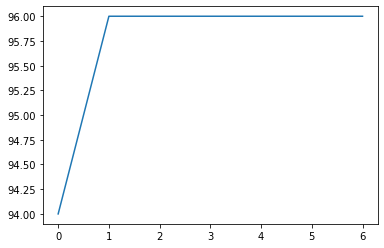

In [41]:
plot(testacc)

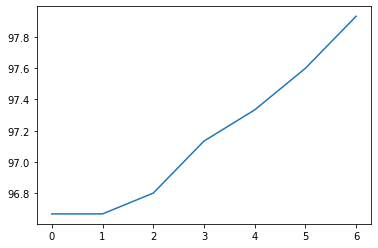

In [42]:
plot(trainacc)

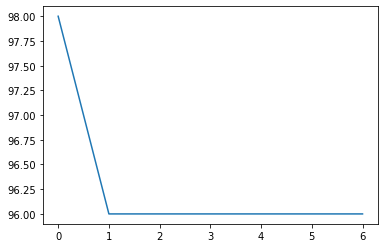

In [43]:
plot(valacc)

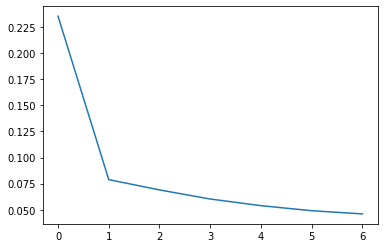

In [44]:
plot(trainloss)

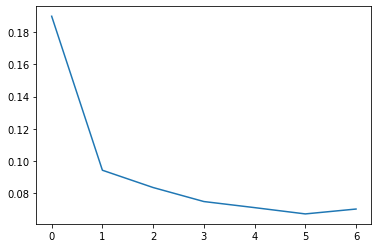

In [45]:
plot(valloss)